Project #5: Stochastic BFGS methods, Gabin Agbalé

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.linalg import norm
import time
from tqdm import tqdm

In [2]:
from scipy.optimize import fmin_l_bfgs_b
from src1.Prob import LogRegPb

# for data loading
from src1.data import *

# loading optimizers
from src1.optimizer import *

## <span style="color:rgb(92,29,79)"> 1 The dataset</span>

We will use the Binary Mushrooms Dataset, coming from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#mushrooms.

It consists in 8124 samples with 112 features divided in 2 classes. All features are binary categories (value originally in $\{1,2\}$, we transform it to $\{0,1\}$).
Every datapoint represents the caracteristics of a given mushroom. 


Data loaded


c:\Users\gabin\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\gabin\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


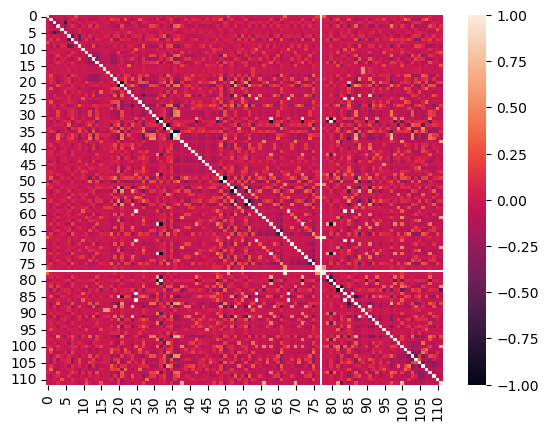

In [3]:
filepath = 'mushrooms.txt'
A, y = get_sampled_data(filepath, sample_rate=1)
y[y==2] = 0

# Draw correlation matrix
arr = A.toarray()
covmat = np.corrcoef(arr.T)
sns.heatmap(covmat)

After observing the correlation matrix, we notice the 77th column of the A matrix contains only 1s, it will serve as the bias term in the logistic regression formulation. 

In [4]:
# initializing an instance of LogReg problem with features matrix and labels given above
prob = LogRegPb(arr, y)
x0 = np.zeros(prob.d)
n = prob.n

# Solution using solver, for comparison purpose
x_min, f_min, _ = fmin_l_bfgs_b(prob.fun, x0, prob.grad, args=(), pgtol=1e-30, factr =1e-30)


c:\Users\gabin\OneDrive\Bureau\M2\Opti4ML\Projet\src1\Prob.py:45: RuntimeWarning: overflow encountered in double_scalars
  denom = (1 + E)**3


## <span style="color:rgb(92,29,79)"> 2 Stochastic, Batch and Full Gradient algorithms</span>

Lets us first compare the training losses between Stochastic Gradient and Full Gradient Descent in the case of Logistic Regression problem on the given dataset.

In [5]:
n_epochs = 100

STOCHASTIC GRADIENT (batch size = 1), 100 epochs

In [8]:
batch_size = 1
n_iter = n_epochs * A.shape[0]//batch_size

x_sg, obj_sg, _ = sgd(x0,prob,x_min, step0=1, 
                 n_iter=n_iter,batch_size=batch_size)

Stochastic Gradient, batch size= 1 / 6093


  0%|          | 0/812400 [00:00<?, ?it/s]

100%|██████████| 812400/812400 [05:34<00:00, 2429.06it/s]


FULL GRADIENT DESCENT (batch size = 1), 100 epochs

In [6]:
batch_size = n
n_iter = n_epochs

x_gd, obj_gd, _ = sgd(x0,prob, x_min, n_iter=n_iter,batch_size=n)

Stochastic Gradient, batch size= 6093 / 6093


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


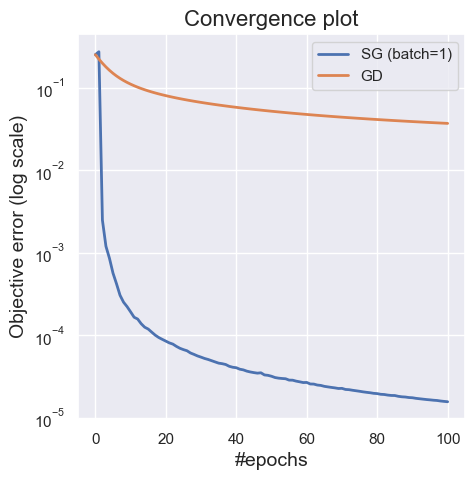

In [11]:
sns.set_theme()
plt.figure(figsize=(5,5))
plt.semilogy(obj_sg-f_min, label="SG (batch=1)", lw=2)
plt.semilogy(obj_gd-f_min, label="GD", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Objective error (log scale)", fontsize=14)
plt.legend()

We apply both algorithms on 50 epochs with constant step size of 1/L, with L the Smoothness constant of the objective function.
We notice that the Stochastic Gradient converges to a lower value of the objective function faster, as expected. Notice that both algorithms have not complete convergence yet at the end of the 50 epochs. Notice also that we only plotted the objective value at every epochs (by matter of computational efficiency), which hides the noisy convergence that we normally observe with Stochastic Gradient.

In [ ]:
n_epochs = 100
batch_size = 8
batch_sizes = [1, 8, 64, 128, 512]
obj = np.zeros((len(batch_sizes), n_epochs))
for i, b in enumerate(batch_sizes):
    _, obj_a, _ = sgd(x0,prob, x_min, n_iter=int(n_epochs * n/b),batch_size=b)
    obj[i] = obj_a[:n_epochs]


Stochastic Gradient, batch size= 1 / 8124


100%|██████████| 812400/812400 [04:14<00:00, 3192.58it/s]


Stochastic Gradient, batch size= 8 / 8124


100%|██████████| 101550/101550 [00:46<00:00, 2188.87it/s]


Stochastic Gradient, batch size= 64 / 8124


100%|██████████| 12693/12693 [00:18<00:00, 669.50it/s]


Stochastic Gradient, batch size= 128 / 8124


100%|██████████| 6346/6346 [00:20<00:00, 310.74it/s]


Stochastic Gradient, batch size= 512 / 8124


100%|██████████| 1586/1586 [00:14<00:00, 106.36it/s]


Let us now experiment with various values of batch size for Stochastic Gradient, on 100 epochs with constant step size 1/L. We notice that the convergence get faster as we lower the batch size. The optimal batch size value is 1 in this case. 
One could think that the samples are ideally independant and identically distributed, in such a way that $$\forall i, \nabla f_i(x) \approx \frac{1}{n} \Sigma_{j=1}^{n} \nabla f_j(x),$$
resulting in the Stochastic Gradient Algorithm descending nearly at each iteration.


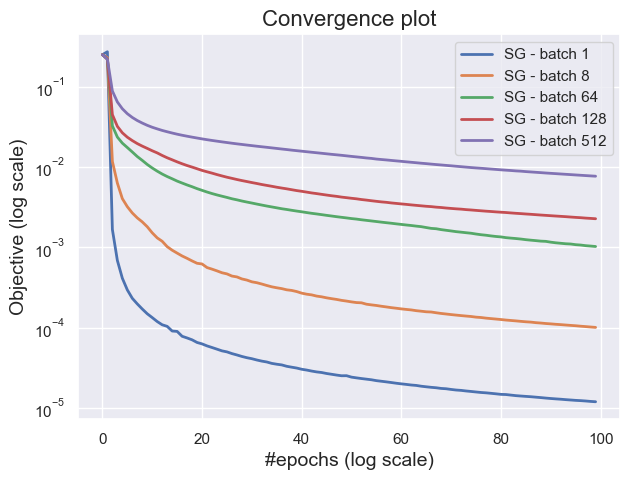

In [27]:
plt.figure(figsize=(7, 5))

for i in range(len(batch_sizes)):
    plt.semilogy((obj[i] - f_min), label=f"SG - batch {batch_sizes[i]}", lw=2)

plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()
plt.show()

## <span style="color:rgb(92,29,79)"> 3. Batch Stochastic quasi-Newton method</span>

Let us first compare Stochastic and Full quasi-Newton methods with Stochastic and Full Gradient methods, on 100 epochs

In [9]:
n_epochs = 100

FULL QUASI-NEWTON METHOD (batch size = n), 100 epochs


Note that we had to lower the Learning rate (from 1/L to 0.01/L) in order to avoid overflow when updating x. 

In [12]:
batch_size = n
n_iter = n_epochs * n // batch_size
x_gd_qn, obj_gd_qn, _ = bfgs(x0,prob, x_min, lr_choice=0.01, 
                             n_iter=n_iter,batch_size=n)

Batch quasi-Newton method, batch size= 8124 / 8124


100%|██████████| 100/100 [00:33<00:00,  2.98it/s]


STOCHASTIC QUASI-NEWTON METHOD (batch size = 1), 100 epochs, with Learning Rate 0.01/L

In [81]:
batch_size = 1
n_iter = n_epochs * n // batch_size
x_sg_qn, obj_sg_qn, _ = bfgs(x0,prob, x_min, lr_choice=0.01,
                              n_iter=n_iter,batch_size=batch_size)

Batch quasi-Newton method, batch size= 1 / 8124


100%|██████████| 812400/812400 [09:40<00:00, 1398.99it/s]


Stochastic and Full Gradient with Learning Rate 0.01/L

In [103]:
batch_size = n
n_iter = n_epochs * n // batch_size
x_gd_01, obj_gd_01, _ = sgd(x0,prob, x_min, lr_choice=0.01, 
                            n_iter=n_iter,batch_size=batch_size)

batch_size = 1
n_iter = n_epochs * n // batch_size
x_sg_01, obj_sg_01, _ = sgd(x0,prob, x_min, lr_choice=0.01, 
                            n_iter=n_iter,batch_size=batch_size)

Stochastic Gradient, batch size= 8124 / 8124


100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


Stochastic Gradient, batch size= 1 / 8124


100%|██████████| 812400/812400 [04:31<00:00, 2995.39it/s]


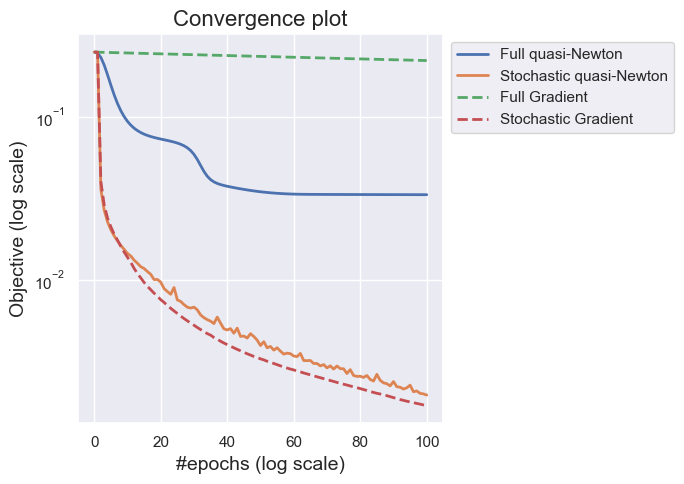

In [104]:
plt.figure(figsize=(7, 5))


plt.semilogy((obj_gd_qn - f_min), label=f"Full quasi-Newton", lw=2)
plt.semilogy((obj_sg_qn - f_min), label=f"Stochastic quasi-Newton", lw=2)
plt.semilogy((obj_gd_01 - f_min), label=f"Full Gradient", lw=2, linestyle='--')
plt.semilogy((obj_sg_01 - f_min), label=f"Stochastic Gradient", lw=2, linestyle='--')
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

We notice that the Full quasi-Newton method converges faster to a lower error than Gradient Descent. Stochastic quasi-Newton and SGD seem to follow the same convergence rate even if SGD performs slightly better.

Batch quasi-Newton method, batch size= 1 / 8124


100%|██████████| 812400/812400 [10:25<00:00, 1299.22it/s]


Batch quasi-Newton method, batch size= 8 / 8124


100%|██████████| 101550/101550 [02:13<00:00, 761.53it/s]


Batch quasi-Newton method, batch size= 64 / 8124


100%|██████████| 12693/12693 [00:29<00:00, 427.69it/s]


Batch quasi-Newton method, batch size= 128 / 8124


100%|██████████| 6346/6346 [00:22<00:00, 285.65it/s]


Batch quasi-Newton method, batch size= 512 / 8124


100%|██████████| 1586/1586 [00:16<00:00, 96.55it/s] 


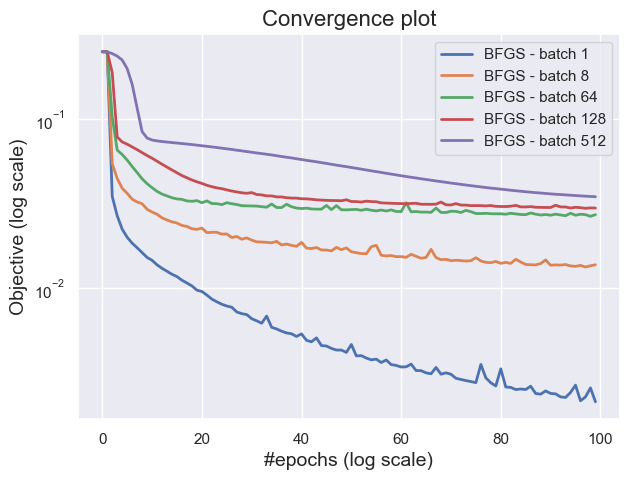

In [101]:
batch_sizes = [1, 8, 64, 128, 512]
obj = np.zeros((len(batch_sizes), n_epochs))

for i, b in enumerate(batch_sizes):
    _, obj_a, _ = bfgs(x0,prob, x_min, lr_choice=0.01, n_iter=int(n_epochs * n/b),batch_size=b)
    obj[i] = obj_a[:n_epochs]



plt.figure(figsize=(7, 5))

for i in range(len(batch_sizes)):
    plt.semilogy((obj[i] - f_min), label=f"BFGS - batch {batch_sizes[i]}", lw=2)

plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Error (log scale)", fontsize=14)
plt.legend()
plt.show()

We notice than the convergence is noisier as we decrease the batch size. BFGS converges to lower values of the objective function, even though it underperforms Classic Stochastic Gradient.

## <span style="color:rgb(92,29,79)"> 3. Limited-Memory Batch Stochastic quasi-Newton method</span>

We now implement a limited-memory version of the BFGS, that approximate the Hessian matrix H based on a limited-memory of the $x_k$ and $\nabla f(x_k)$ values. We test both the Stochastic and the full version on a memory of 0, 5 and 10 and compare it to the classic BFGS. Please note that the memory parameter corresponds to $m+1$ as defined in the formula.

FULL AND STOCHASTIC l-BFGS METHOD, LR=0.1/L, 100 epochs

In [ ]:
memory = [1, 6, 11]
colors = ['r', 'g', 'b']

obj_gd = np.zeros((len(memory), n_epochs))
obj_sg = np.zeros((len(memory), n_epochs))

# full gradient
for i, m in enumerate(memory):
    b = n
    _, obj_a = l_bfgs(x0,prob, x_min, lr_choice=0.1, n_iter=int(n_epochs * n/b),batch_size=b, 
                         memory=m)
    obj_gd[i] = obj_a[:n_epochs]

# full gradient
for i, m in enumerate(memory):
    b = 1
    _, obj_a = l_bfgs(x0,prob, x_min, lr_choice=0.1, n_iter=int(n_epochs * n/b),batch_size=b,
                         memory=m)
    obj_sg[i] = obj_a[:n_epochs]


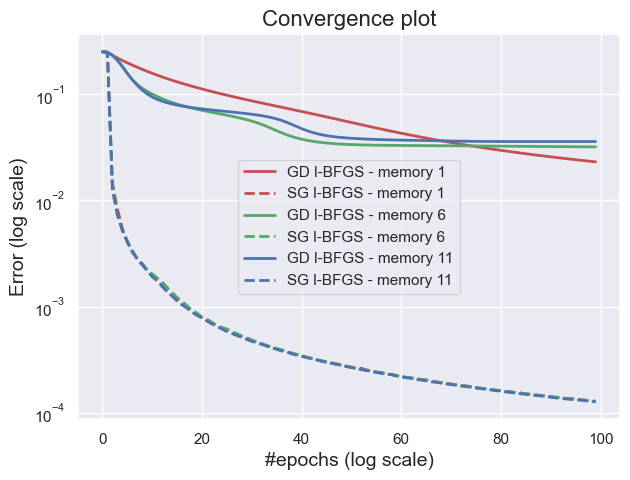

In [125]:
plt.figure(figsize=(7, 5))

for i in range(len(memory)):
    plt.semilogy((obj_gd[i] - f_min), label=f"GD l-BFGS - memory {memory[i]}", lw=2, color=colors[i])
    plt.semilogy((obj_sg[i] - f_min), label=f"SG l-BFGS - memory {memory[i]}", lw=2, color=colors[i],
                 linestyle='--')

plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Error (log scale)", fontsize=14)
plt.legend()
plt.show()

We notice that the memory parameter impact on SG l-BFGS is negligeable. Surprisingly, it seems that the GD - l-BFGS performs very well (in terms of error) when set with a memory of 1, even though it has not reached convergence yet within 100 epochs.